<a href="https://colab.research.google.com/github/OlgaNezh/PyTorch/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22HW_8_Pytorch_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Урок 8. Generative Adversarial Networks
Обучить генератор создавать точки, которые будут лежать на графике функции
y = sin(x)/x - x/10

При выполнении данного задания структура GAN остается той же, но Вам нужно:
1. Сгенерировать настоящие данные
2. Изменить архитектуру дискриминатора и генератора
3. Построить графики



In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from IPython import display

In [ ]:
def func(x):
    
    y = (np.sin(x)/x) - (x/10)
    return y

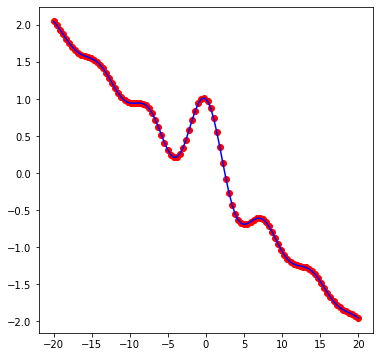

In [ ]:
# визуализация графика функции
fig, ax = plt.subplots(figsize=(6, 6))

x = np.linspace(-20, 20, 100)

ax.scatter(x, y = func(x), color='red')

plt.plot(x, func(x), color='blue')

plt.show()

In [ ]:
#функция генерации точек, принадлежащих графику заданной функции
def point_generator(ax, n):

    points = pd.DataFrame([(x, func(x)) for x in np.random.uniform(-ax, ax, size=(1, n))[0]], columns=['x', 'y'])
    
    return points

In [ ]:
#датасет с реальными данными (чем больше точек берем, тем лучше результат модели GAN)
df_train = point_generator(10, 500000)
df_train

,x,y
0,-8.832909,0.946454
1,1.771403,0.376063
2,7.491446,-0.624336
3,9.508097,-0.959563
4,-6.689365,0.728001
...,...,...
499995,-7.294874,0.845696
499996,2.010573,0.248987
499997,-1.085123,0.923499
499998,-1.221403,0.891404


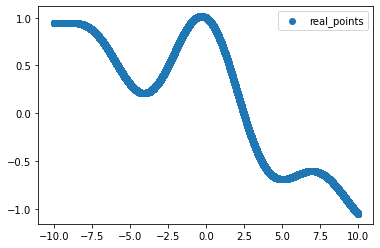

In [ ]:
#отрисовка реальных данных
x,y = df_train.values.T
plt.scatter(x,y,label='real_points')
plt.legend()
plt.show()

In [ ]:
scaler = MinMaxScaler()
data_train = scaler.fit_transform(df_train)  
data_train = torch.FloatTensor(data_train).float()
data_train

tensor([[0.0584, 0.9668],
        [0.5886, 0.6912],
        [0.8746, 0.2078],
        ...,
        [0.4457, 0.9558],
        [0.4389, 0.9402],
        [0.9814, 0.0342]])

In [ ]:
# класс датасета
class MyOwnClass(torch.utils.data.Dataset):
   
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        point = self._data[idx] 
       
        return point

In [ ]:
# создание представителя датасета и его даталоадер
train_dataset = MyOwnClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [ ]:
# элементы тренировочного даталоадера
for idx, batch in enumerate(train_loader):
    print(batch.shape) # 128 батчей с 2 признаками
    break

torch.Size([128, 2])


In [ ]:
# Функция для построения графиков
def plot_points(gen_points, real_points):
    fig, ax = plt.subplots(figsize=(6, 6))

    a,b = (real_points.detach()).T
    plt.scatter(a,b, color='green',label='real_points') 
    
    x, y = (gen_points.detach()).T
    plt.scatter(x,y, color='red', label='generated_points') 

    plt.legend()
    plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
             nn.Linear(1024, 2),
             nn.Linear(2, 2),
             nn.Tanh()
        )
        
    def forward(self, z):
        new_point = self.model(z)
        new_point = new_point.reshape(-1, 2)
        return new_point 

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid()
        )
  

    def forward(self, img):
        img_flat = img
        validity = self.model(img_flat)
        return validity

In [ ]:
n_epochs = 20  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

batch_size = 128

In [ ]:
generator = Generator()
discriminator = Discriminator()

# опитимизатор для каждой сети
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# функция ошибки
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

<Figure size 432x288 with 0 Axes>

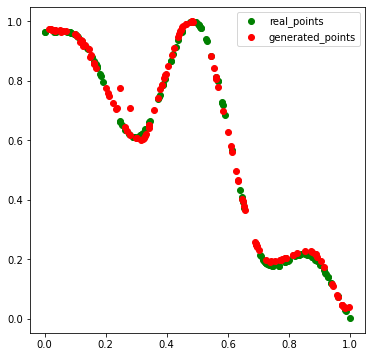

[Epoch 19/20] [Batch 3786/3906]|[D loss: 0.6929342746734619] [G loss: 0.6913881897926331]


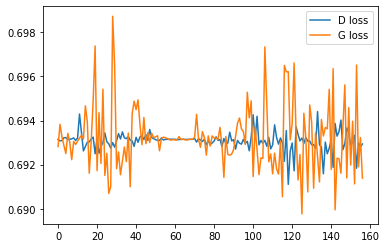

In [ ]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, points in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0) #(B,1) -- столбец-лейблов 1
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)  #(B,1)  -- столбец-лейблов 0

        real_points = points.type(torch.FloatTensor) #(B,2) -- реальные данные

        # Генерация шума (B,latent_dim)
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)   #(B,2) -- сгенерированные данные
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_points)  #(B,1)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points) #(B,1)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))) #(B,latent_dim)
        
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)  #(B,2)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)  #(B,1)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()
                display.clear_output(wait=False)
                plot_points(gen_points, real_points)
                
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                d_loss = d_loss.detach()  #новый тензор без градиента
                g_loss = g_loss.detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()        
